In [1]:
import torch
import sys
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler, AutoConfig
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
from pathlib import Path
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import sys
from pathlib import Path
import torch.nn as nn

# Importing the custom preprocessor
sys.path.append(str(Path.cwd().parents[1] / "src"))
from preprocessing.preprocess_dataset import DistilBertPreprocessor
from transformers import (
    AutoConfig, AutoModelForSequenceClassification, AdamW, get_scheduler
)
import numpy as np

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ujjwalpoudel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
PROJECT_ROOT = Path.cwd().parents[1]  # Adjust based on notebook location

DATA_DIR = Path("/Volumes/MACBACKUP/final_datasets/")   # The dataset folder
MODEL_DIR = PROJECT_ROOT / "models" / "distilbert-v4"  # Folder to save model checkpoints
PLOT_DIR = PROJECT_ROOT / "plots" / "distilbert-v4"   # Folder to save plots

# Create directories if they do not exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Adding src folder to sys.path if you have helper modules
sys.path.append(str(PROJECT_ROOT / "src"))

# Model & Training Config
MODEL_NAME = "distilbert-base-uncased"
LEARNING_RATE = 2e-5      # Good starting point for DistilBERT fine-tuning
EPOCHS = 10               # Avoid overly long training
BATCH_SIZE = 8
EARLY_STOPPING_PATIENCE = 3


In [3]:
# DATA PREPARATION
#  PYTORCH DATASET CLASS
class DepressionDataset(Dataset):
    """Custom Dataset class for our depression text data."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # The encodings are already tensors from the tokenizer
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [4]:
def evaluate(model, dataloader, device, loss_fn):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return avg_loss, acc, f1

In [5]:
def plot_metrics(history, model_name="distilbert-v4", base_dir="plots", show=True):
    """
    Generates, displays, and saves training/validation metric plots.

    Args:
        history (dict): Contains 'train_loss', 'val_loss', 'train_accuracy',
                        'val_accuracy', and 'val_f1'.
        model_name (str): Subfolder name under 'plots/' (e.g., "distilbert-v4").
        base_dir (str or Path): Base directory for saving plots.
        show (bool): If True, display plots inline in notebook.
    """
    # Prepare output directory
    output_dir = Path(base_dir) / model_name
    output_dir.mkdir(parents=True, exist_ok=True)

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot 1: Loss Curve
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title(f'{model_name.upper()} - Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    loss_path = output_dir / 'training_validation_loss.png'
    plt.savefig(loss_path, dpi=300)
    if show:
        plt.show()
    plt.close()

    # Plot 2: Accuracy & F1 Curve
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_accuracy'], 'c-o', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'g-o', label='Validation Accuracy')
    plt.plot(epochs, history['val_f1'], 'm-o', label='Validation F1-Score')
    plt.title(f'{model_name.upper()} - Accuracy and F1 Trends')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    metrics_path = output_dir / 'accuracy_f1.png'
    plt.savefig(metrics_path, dpi=300)
    if show:
        plt.show()
    plt.close()

    print(f"Saved plots to: {output_dir}")
    print(f"   - Loss curve: {loss_path}")
    print(f"   - Accuracy & F1 curve: {metrics_path}")


In [6]:
# Device Setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (GPU) for training.")
else:
    device = torch.device("cpu")
    print("MPS not available. Using CPU for training.")

Using MPS (GPU) for training.


### Data loading and Pre-procesing

In [7]:
# Data Loading and Preprocessing
preprocessor = DistilBertPreprocessor()

# Loading raw data
print("Loading and preprocessing data...")
X_train_df, y_train_df = preprocessor.load_and_preprocess(DATA_DIR / "final_train_dataset.csv")
X_dev_df, y_dev_df = preprocessor.load_and_preprocess(DATA_DIR / "final_dev_dataset.csv")

# Sentence-aware chunking
X_train_chunked, y_train_chunked = preprocessor.chunk_dataframe(X_train_df, y_train_df, strategy="sentence_aware", chunk_size=510, overlap=2)
X_dev_chunked, y_dev_chunked = preprocessor.chunk_dataframe(X_dev_df, y_dev_df, strategy="sentence_aware", chunk_size=510, overlap=2)

# Tokenization
train_encodings = preprocessor.tokenize(X_train_chunked['text'])
dev_encodings = preprocessor.tokenize(X_dev_chunked['text'])

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading and preprocessing data...


Token indices sequence length is longer than the specified maximum sequence length for this model (2218 > 512). Running this sequence through the model will result in indexing errors


Successfully loaded /Volumes/MACBACKUP/final_datasets/final_train_dataset.csv. Found 107 records.
Text cleaning complete.
Data prepared. X shape: (107, 1), y shape: (107, 1)

Successfully loaded /Volumes/MACBACKUP/final_datasets/final_dev_dataset.csv. Found 35 records.
Text cleaning complete.
Data prepared. X shape: (35, 1), y shape: (35, 1)

Starting chunking with strategy: 'sentence_aware'...
Chunking complete. Original docs: 107, Total chunks: 407
Starting chunking with strategy: 'sentence_aware'...
Chunking complete. Original docs: 35, Total chunks: 147
Tokenizing for DistilBERT with max_length=512...
Tokenizing for DistilBERT with max_length=512...


### DATASET AND DATALOADER

In [8]:
train_labels = y_train_chunked['label'].tolist()
dev_labels = y_dev_chunked['label'].tolist()

In [9]:
# Compute class weights
label_counts = y_train_chunked['label'].value_counts().sort_index()
class_sample_count = torch.tensor(label_counts.values, dtype=torch.float)
class_weights = 1. / class_sample_count
class_weights = class_weights / class_weights.sum() * 2  # normalizes roughly to [1, 2] range

print(f"Class Weights: {class_weights}")

Class Weights: tensor([0.5553, 1.4447])


In [10]:
# Datasets
train_dataset = DepressionDataset(train_encodings, train_labels)
dev_dataset = DepressionDataset(dev_encodings, dev_labels)

In [11]:
# Dataloaders (NO sampler)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Model Setup

In [12]:
def build_distilbert_classifier(num_labels=2):
    config = AutoConfig.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        attention_dropout=0.3,
        dropout=0.2
    )
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    return model, optimizer

In [13]:
model, optimizer = build_distilbert_classifier(num_labels=2)
model.to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.

In [14]:
# Scheduler
num_training_steps = EPOCHS * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

### Training Loop

In [15]:
history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': []}
best_val_accuracy = 0.0
patience_counter = 0
start_time = time.time()

In [16]:
for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    model.train()
    total_train_loss = 0
    epoch_preds, epoch_labels = [], []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        epoch_preds.extend(preds.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.set_postfix(loss=loss.item())

    progress_bar.close()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(epoch_labels, epoch_preds)
    history['train_loss'].append(avg_train_loss)
    history['train_accuracy'].append(train_accuracy)

    print("Evaluating on validation set...")
    val_loss, val_accuracy, val_f1 = evaluate(model, dev_loader, device, loss_fn)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1:.4f}")

    if val_accuracy > best_val_accuracy:
        print(f"Validation accuracy improved from {best_val_accuracy:.4f} → {val_accuracy:.4f}. Saving model...")
        best_val_accuracy = val_accuracy
        patience_counter = 0
    
        # Save the model and tokenizer to your existing folder
        model.save_pretrained(MODEL_DIR)
        
        preprocessor.tokenizer.save_pretrained(MODEL_DIR)
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epoch(s).")

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Stopping early after {patience_counter} epochs with no improvement.")
        break



--- Epoch 1/10 ---


Training:   0%|          | 0/51 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating on validation set...


Epoch 1 | Train Loss: 0.6935 | Train Acc: 0.5430 | Val Loss: 0.6944 | Val Acc: 0.5986 | Val F1: 0.0000
Validation accuracy improved from 0.0000 → 0.5986. Saving model...

--- Epoch 2/10 ---


Evaluating on validation set...


Epoch 2 | Train Loss: 0.6930 | Train Acc: 0.6683 | Val Loss: 0.6845 | Val Acc: 0.6122 | Val F1: 0.3596
Validation accuracy improved from 0.5986 → 0.6122. Saving model...

--- Epoch 3/10 ---


Evaluating on validation set...


Epoch 3 | Train Loss: 0.6764 | Train Acc: 0.6118 | Val Loss: 0.6786 | Val Acc: 0.5442 | Val F1: 0.3964
No improvement in validation accuracy for 1 epoch(s).

--- Epoch 4/10 ---


Evaluating on validation set...


Epoch 4 | Train Loss: 0.6300 | Train Acc: 0.7101 | Val Loss: 0.6508 | Val Acc: 0.5986 | Val F1: 0.5755
No improvement in validation accuracy for 2 epoch(s).

--- Epoch 5/10 ---


Evaluating on validation set...


Epoch 5 | Train Loss: 0.5507 | Train Acc: 0.7568 | Val Loss: 0.7314 | Val Acc: 0.5238 | Val F1: 0.5833
No improvement in validation accuracy for 3 epoch(s).
Stopping early after 3 epochs with no improvement.


In [17]:
end_time = time.time()
print(f"\nTraining finished in {(end_time - start_time)/60:.2f} minutes.")


Training finished in 24.79 minutes.


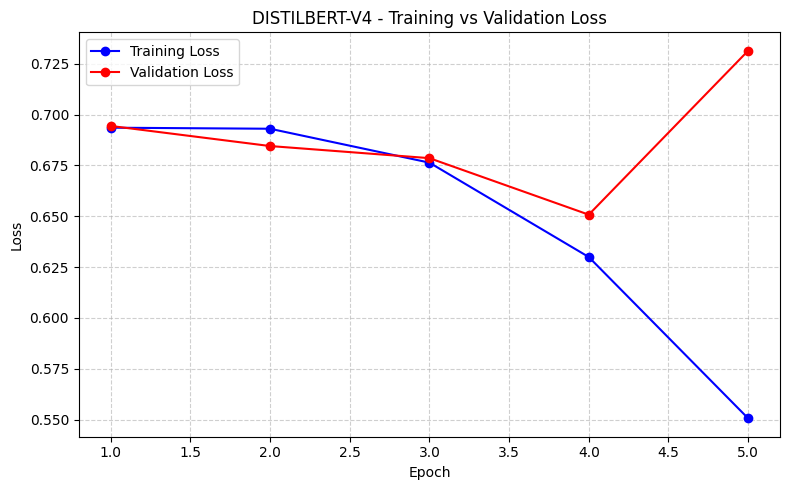

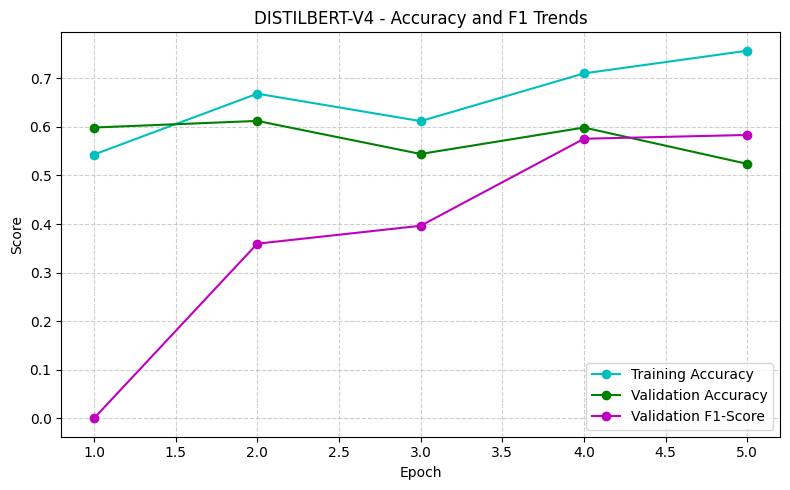

Saved plots to: plots/distilbert-v4
   - Loss curve: plots/distilbert-v4/training_validation_loss.png
   - Accuracy & F1 curve: plots/distilbert-v4/accuracy_f1.png


In [20]:
plot_metrics(history)